In [1]:
# trying a simple training example
# the custom model
import torch
import torch.nn as nn
from my_extension import (
    CustomLinear, 
    CustomReLU
)

import matplotlib.pyplot as plt
import numpy as np



In [2]:
"""Define a few models for comparison, including a standard (all built in ops), custom, and mixed model
"""

bias_set = True

class CustomNeuralNet(nn.Module):
    def __init__(self, 
                 input_size, 
                 hidden_size, 
                 hidden_size_2,
                 output_size):
        super(CustomNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size, bias=bias_set)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = CustomLinear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class StandardNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(StandardNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=bias_set)
        self.ac1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

#3 comparing the custom net with a standard net
class MixedNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super(MixedNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size, bias=bias_set)
        self.ac1 = CustomReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size_2, bias=bias_set)
        self.ac2 = CustomReLU()
        self.fc3 = nn.Linear(hidden_size_2, output_size, bias=bias_set)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

class TinyNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TinyNeuralNet, self).__init__()
        self.fc1 = CustomLinear(input_size, hidden_size)
        self.ac1 = CustomReLU()
        self.fc2 = CustomLinear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x


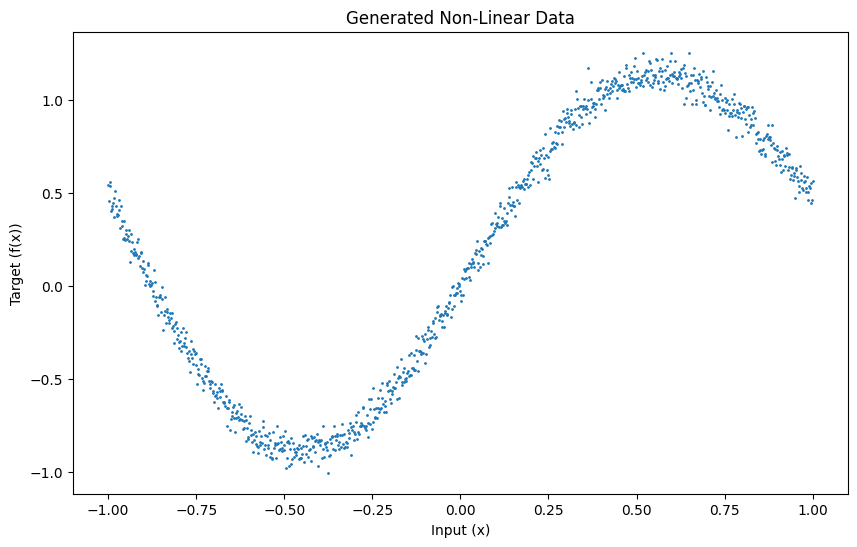

In [3]:
# Settings
num_samples = 1000  # Number of data points
x_range = [-1, 1]  # Range of x values
noise_factor = 0.05  # Noise factor for the data

# Generate input features
inputs = torch.linspace(x_range[0], x_range[1], steps=num_samples).unsqueeze(1)

# Generate targets based on the non-linear function
targets = torch.sin(1 * np.pi * inputs) + 0.5 * torch.pow(inputs, 2)

# Add noise to targets
targets_noisy = targets + torch.randn(targets.shape) * noise_factor

# Plot the generated data
plt.figure(figsize=(10, 6))
plt.scatter(inputs.numpy(), targets_noisy.numpy(), s=1)
plt.title("Generated Non-Linear Data")
plt.xlabel("Input (x)")
plt.ylabel("Target (f(x))")
plt.show()

# Split into training and testing sets
train_ratio = 0.8
num_train = int(num_samples * train_ratio)
train_inputs = inputs[:num_train]
train_targets = targets_noisy[:num_train]

test_inputs = inputs[num_train:]
test_targets = targets_noisy[num_train:]

# Calculate mean and standard deviation of the inputs
inputs_mean = train_inputs.mean()
inputs_std = train_inputs.std()

# Normalize (scale and center) the inputs
train_inputs_normalized = (train_inputs - inputs_mean) / inputs_std
test_inputs_normalized = (test_inputs - inputs_mean) / inputs_std

# Calculate mean and standard deviation of the targets
targets_mean = train_targets.mean()
targets_std = train_targets.std()

# Normalize (scale and center) the targets
train_targets_normalized = (train_targets - targets_mean) / targets_std
test_targets_normalized = (test_targets - targets_mean) / targets_std


In [4]:
# move to the MPS device
train_inputs = train_inputs_normalized.to('mps')
train_targets = train_targets_normalized.to('mps')

In [5]:
# Initialize the networks and move to MPS device
num_features = 1
hidden_size = 5
hidden_size_2 = 5
output_size = 1

standard_model = None
standard_model = StandardNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2, 
    output_size=1
).to('mps')

custom_model = None
custom_model = CustomNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')

mixed_model = None
mixed_model = MixedNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    hidden_size_2=hidden_size_2,
    output_size=output_size
).to('mps')


tiny_model = None
tiny_model = TinyNeuralNet(
    input_size=num_features,
    hidden_size=hidden_size,
    output_size=output_size
).to('mps')

In [6]:
# set the model to the model of choice
optimizer = None 
loss = None
criterion = None

model = custom_model

# set criterion and choose adam optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# Simple Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(train_inputs)
    loss = criterion(outputs, train_targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
    # if (epoch+1) % 100 == 0:
    #     for name, param in model.named_parameters():
    #         print(f"Gradients of {name}: {param.grad}")


Epoch [10/10000], Loss: 1.0849
Epoch [20/10000], Loss: 1.0683
Epoch [30/10000], Loss: 1.0536
Epoch [40/10000], Loss: 1.0399
Epoch [50/10000], Loss: 1.0282
Epoch [60/10000], Loss: 1.0189
Epoch [70/10000], Loss: 1.0110
Epoch [80/10000], Loss: 1.0037
Epoch [90/10000], Loss: 0.9968
Epoch [100/10000], Loss: 0.9899
Epoch [110/10000], Loss: 0.9830
Epoch [120/10000], Loss: 0.9759
Epoch [130/10000], Loss: 0.9687
Epoch [140/10000], Loss: 0.9613
Epoch [150/10000], Loss: 0.9536
Epoch [160/10000], Loss: 0.9457
Epoch [170/10000], Loss: 0.9376
Epoch [180/10000], Loss: 0.9292
Epoch [190/10000], Loss: 0.9205
Epoch [200/10000], Loss: 0.9116
Epoch [210/10000], Loss: 0.9025
Epoch [220/10000], Loss: 0.8931
Epoch [230/10000], Loss: 0.8834
Epoch [240/10000], Loss: 0.8735
Epoch [250/10000], Loss: 0.8634
Epoch [260/10000], Loss: 0.8530
Epoch [270/10000], Loss: 0.8425
Epoch [280/10000], Loss: 0.8317
Epoch [290/10000], Loss: 0.8208
Epoch [300/10000], Loss: 0.8096
Epoch [310/10000], Loss: 0.7983
Epoch [320/10000]

KeyboardInterrupt: 

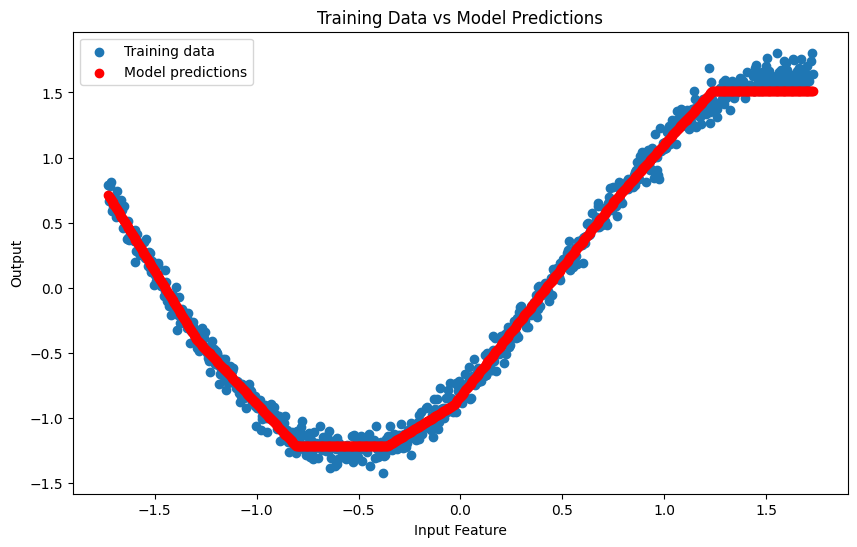

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# Assuming `train_inputs` and `train_outputs` are your training data
# And `model` is your trained model

# Move the data to the same device as the model
#train_inputs, train_outputs = train_inputs.to('mps'), train_targets.to('mps')

# Get predictions from the model
with torch.no_grad():
    predictions = model(train_inputs)

# Convert tensors to numpy for plotting
train_inputs_np = train_inputs.cpu().numpy()
train_outputs_np = train_targets.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Assuming a single feature for simplicity in plotting
plt.figure(figsize=(10, 6))
plt.scatter(train_inputs_np[:, 0], train_outputs_np[:, 0], label='Training data')
plt.scatter(train_inputs_np[:, 0], predictions_np[:, 0], label='Model predictions', color='red')
plt.xlabel('Input Feature')
plt.ylabel('Output')
plt.legend()
plt.title('Training Data vs Model Predictions')
plt.show()


In [8]:
predictions_np[:, 0]

array([-4.61773491e+00, -3.93430114e-01, -3.92442852e-01, -3.91455531e-01,
       -3.90468299e-01, -3.89481038e-01, -3.88493717e-01, -3.87506425e-01,
       -3.86519194e-01, -3.85531932e-01, -3.84544641e-01, -3.83557379e-01,
       -2.14569584e-01, -2.90405184e-01, -6.72466040e-01, -6.29010141e-01,
       -3.81479442e-01, -4.30256099e-01, -3.76646429e-01, -3.75659168e-01,
       -3.74671876e-01, -3.73684555e-01, -3.72697294e-01, -3.71710032e-01,
       -3.70722741e-01, -3.29671234e-01, -1.88303456e-01, -3.67760897e-01,
       -3.66773605e-01, -3.65786314e-01, -3.64799052e-01, -3.63811791e-01,
       -3.62824500e-01, -3.61837208e-01, -3.60849947e-01, -3.59862685e-01,
       -3.58875394e-01, -3.57888132e-01, -1.01777756e+00, -8.96205604e-01,
       -3.54926288e-01, -3.53939027e-01, -3.52951735e-01, -3.51964474e-01,
       -3.50977212e-01, -3.49989891e-01, -3.49002659e-01, -3.48015368e-01,
       -3.47028047e-01, -3.46040785e-01, -3.45053494e-01,  4.56667924e-03,
       -6.62361860e-01, -

In [10]:
-1.90257382e+00

torch.float32

In [8]:
# vanishing gradient? 
for name, param in model.named_parameters():
    print(f"Gradients of {name}: {param.grad}")


Gradients of fc1.weight: tensor([[ 0.0004],
        [ 0.0002],
        [ 0.0034],
        [ 0.0022],
        [-0.0003]], device='mps:0')
Gradients of fc1.bias: tensor([-0.0400, -0.0034, -0.0761, -0.0475,  0.1092], device='mps:0')
Gradients of fc2.weight: tensor([[ 2.4501e-05,  6.1112e-04, -1.6796e-03, -1.2656e-03,  0.0000e+00],
        [ 6.6731e-06,  2.6973e-06, -6.1485e-04, -4.5225e-04,  0.0000e+00],
        [-9.4585e-07,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.1706e-05],
        [ 2.8092e-05,  7.0068e-04, -1.9259e-03, -1.4511e-03,  0.0000e+00],
        [ 2.5404e-05,  4.0045e-04, -2.3773e-04,  3.5265e-04, -5.8292e-04]],
       device='mps:0')
Gradients of fc2.bias: tensor([-0.0788, -0.0215, -0.0057, -0.0903,  0.1577], device='mps:0')
Gradients of fc3.weight: tensor([[-6.1390e-03,  1.8375e-03,  2.2224e-05, -2.9609e-03,  8.9360e-04]],
       device='mps:0')
Gradients of fc3.bias: tensor([0.5607], device='mps:0')


In [26]:
# vanishing gradient? 
for name, param in model.named_parameters():
    print(f"Values of {name}: {param}")


Values of fc1.weight: Parameter containing:
tensor([[ 0.1360],
        [ 0.9674],
        [-1.1944],
        [-1.2698],
        [-1.4850]], device='mps:0', requires_grad=True)
Values of fc1.bias: Parameter containing:
tensor([-1.3885, -1.0289,  2.0568,  1.9579,  2.0204], device='mps:0',
       requires_grad=True)
Values of fc2.weight: Parameter containing:
tensor([[-0.1133,  0.1705,  0.9194,  0.9520,  1.0655],
        [ 0.3961,  0.4371, -0.0853,  0.2873, -0.3558],
        [-0.7498,  0.1946, -0.0791, -0.2562, -0.0978],
        [ 0.3634, -0.0381,  0.4772, -0.1316, -0.3436],
        [ 0.7696,  0.5694, -0.3407,  0.3640, -0.0447]], device='mps:0',
       requires_grad=True)
Values of fc2.bias: Parameter containing:
tensor([ 1.8407, -1.3476,  1.3586, -1.7185, -1.1064], device='mps:0',
       requires_grad=True)
Values of fc3.weight: Parameter containing:
tensor([[-0.1051,  1.3571, -0.5630,  0.8001,  0.6373]], device='mps:0',
       requires_grad=True)
Values of fc3.bias: Parameter containing

In [26]:
model

StandardNeuralNet(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)